Muhammad Hassaan Azam

AI/ML Intern

DHC 831


# Pneumonia Detection from Chest X-Rays


### What is Pneumonia?  
Pneumonia is an inflammatory condition of the lungs that primarily affects the small air sacs known as alveoli. Symptoms typically include a combination of a productive or dry cough, chest pain, fever, and difficulty breathing. The severity of the condition can vary.  

Pneumonia is usually caused by infections from viruses or bacteria, and less commonly by other microorganisms, certain medications, or conditions such as autoimmune diseases. Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, reduced ability to cough (e.g., following a stroke), and a weakened immune system.  

Diagnosis is often based on symptoms and a physical examination. Additional tests such as chest X-rays, blood tests, and sputum cultures may help confirm the diagnosis.  

The disease can be classified based on where it was acquired, such as:  
- **Community-acquired pneumonia (CAP)**  
- **Hospital-acquired pneumonia (HAP)**  
- **Healthcare-associated pneumonia (HCAP)**  

### Description of the Pneumonia Dataset  
The dataset is organized into three folders: **train**, **test**, and **validation (val)**. Each folder contains subfolders for the two image categories: **Pneumonia** and **Normal**.  

It consists of **5,850+ chest X-ray images** (in JPEG format) categorized into two classes:  
1. **Pneumonia**  
2. **Normal**  

The chest X-ray images (anterior-posterior view) were collected from retrospective cohorts of pediatric patients aged one to five years at the Guangzhou Women and Children’s Medical Center in Guangzhou, China. All imaging was performed as part of routine clinical care.  

### Data Quality  
To ensure high-quality data:  
- Low-quality or unreadable scans were removed during the initial quality control process.  
- The diagnoses associated with the images were reviewed and graded by **two expert physicians**.  
- To minimize grading errors, the evaluation set was further reviewed by a **third expert** before being approved for training the AI system.  

This rigorous process ensures the dataset’s reliability for developing and evaluating AI models for pneumonia detection.


## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image

Importing kagglehub so we can download data direct from kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [ ]:
import os
# List all image files recursively
# Skin_img = glob.glob(os.path.join(path, '**', '*.jpg'), recursive=True)

Chest_img = tf.io.gfile.glob(str(path + '/chest_xray/train/*/*'))
Chest_img.extend(tf.io.gfile.glob(str(path + '/chest_xray/val/*/*')))
Chest_img.extend(tf.io.gfile.glob(str(path + '/chest_xray/test/*/*')))
# Print the paths of the first few images
# print(Skin_img)
for imgname in Chest_img[:3]:
    print(imgname)

/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0771-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1294-0001-0002.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0675-0001.jpeg


## Analyzing the Dataset

Total image count in training and testing datasets

In [ ]:
train_data = []
test_data = []
val_data = []

for img_path in Chest_img:
    if 'train' in img_path:
        train_data.append(img_path)
    elif 'val' in img_path:
        val_data.append(img_path)
    elif 'test' in img_path:
        test_data.append(img_path)

print(f"Total Training Data Images: {len(train_data)}")
print(f"Total Testing Data Images: {len(test_data)}")
print(f"Total Validation Data Images: {len(val_data)}")
print(f"Sum of Training, Validating and Testing Images: {len(train_data)+len(val_data)+len(test_data)}")

Total Training Data Images: 5216
Total Testing Data Images: 624
Total Validation Data Images: 16
Sum of Training, Validating and Testing Images: 5856


Validation dataset is very small, which is not even 1%.

In [ ]:
total_images = len(train_data) + len(val_data) + len(test_data)
train_percent = (len(train_data) / total_images) * 100
val_percent = (len(val_data) / total_images) * 100
test_percent = (len(test_data) / total_images) * 100

print(f"Train data: {train_percent:.2f}%")
print(f"Validation data: {val_percent:.2f}%")
print(f"Test data: {test_percent:.2f}%")

Train data: 89.07%
Validation data: 0.27%
Test data: 10.66%


We will combine train, val, and test datasets and later make new splits.

In [ ]:
# we combine all images
all_images = train_data + val_data + test_data
all_images[:3]

['/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0771-0001.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1294-0001-0002.jpeg',
 '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0675-0001.jpeg']

Counting number of images in both classes

In [ ]:
import os

nor_data = []
pne_data = []


for img in all_images:
    if 'NORMAL' in os.path.basename(os.path.dirname(img)):
        nor_data.append(img)
    elif 'PNEUMONIA' in os.path.basename(os.path.dirname(img)):
        pne_data.append(img)


print(f"Number of Images of NORMAL Class: {len(nor_data)}")
print(f"Number of Images of PNEUMONIA Class: {len(pne_data)}")
# total
print(f"Total Number of Images: {len(nor_data) + len(pne_data)}")




Number of Images of NORMAL Class: 1583
Number of Images of PNEUMONIA Class: 4273
Total Number of Images: 5856


## Plotting Normal and Pneumonia Class Images Side by Side

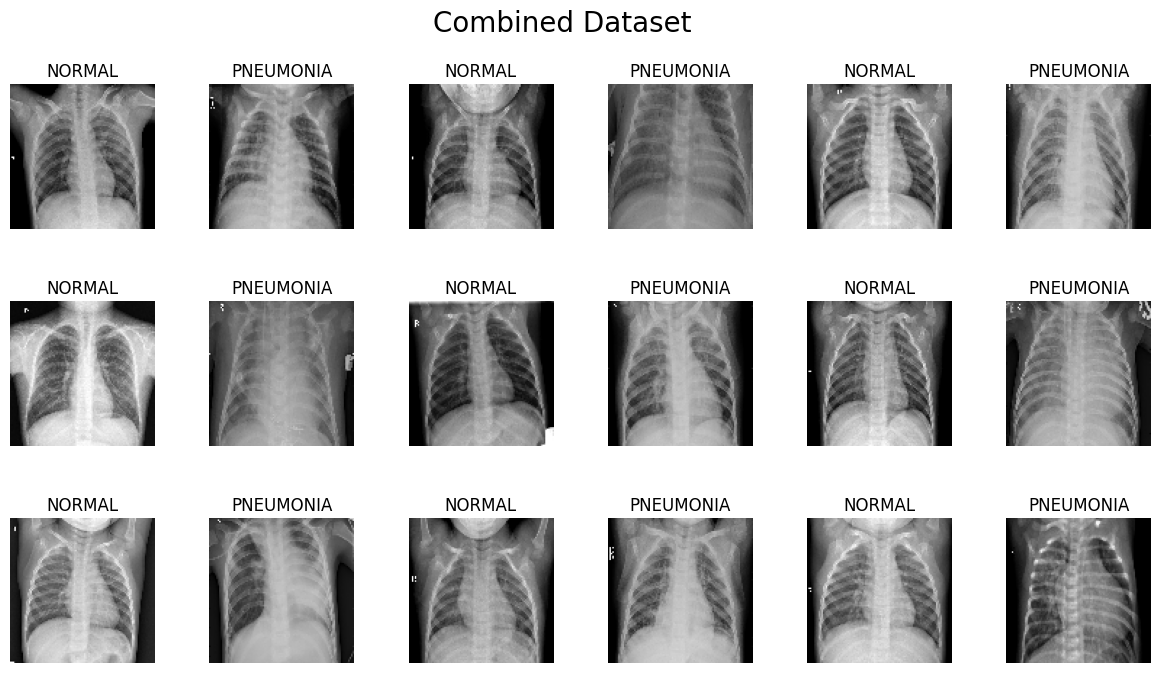

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras.utils as image

# Assuming Nor_data and Pne_data are lists of image paths
some_Nor_data = np.random.randint(0, len(nor_data), 9)
some_Pne_data = np.random.randint(0, len(pne_data), 9)

plt.figure(figsize=(15, 15))

# Adjust subplot parameters to provide more space for titles
plt.subplots_adjust(hspace=0.5, top=0.93)  # Adjust top to make space for the main title

# Add main title
plt.suptitle('Combined Dataset', fontsize=20)

s = 0
for num in some_Nor_data:
    img = image.load_img(nor_data[num], target_size=(100, 100))
    img = image.img_to_array(img)

    plt.subplot(6, 6, 2*s+1)
    plt.axis('off')
    plt.title('NORMAL')
    plt.imshow(img.astype('uint8'))
    s += 1

s = 1
for num in some_Pne_data:
    img = image.load_img(pne_data[num], target_size=(100, 100))
    img = image.img_to_array(img)

    plt.subplot(6, 6, 2*s)
    plt.axis('off')
    plt.title('PNEUMONIA')
    plt.imshow(img.astype('uint8'))
    s += 1

plt.show()


## Preprocessing Images

We are resizing images and assigning labels to the classes.

In [ ]:
nor_arr = []
pne_arr = []

for img in nor_data:

    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (224, 224), interpolation = cv2.INTER_LINEAR)
    nor_arr.append([n_img_size, 0])

for img in pne_data:
    p_img = cv2.imread(img, cv2.IMREAD_COLOR)
    p_img_size = cv2.resize(p_img, (224, 224), interpolation = cv2.INTER_LINEAR)
    pne_arr.append([p_img_size, 1])

In [ ]:
# count
print(len(nor_arr))
print(len(pne_arr))

1583
4273


Combine and shuffle the testing data from both classes, then normalize the image pixel values to the range [0, 1] by dividing by 255. Also, separate the labels and features into different variables.

In [ ]:
import numpy as np
X = []
y = []


# Extend the lists instead of using concatenate
chest_img_arr = nor_arr + pne_arr
random.shuffle(chest_img_arr)

for feature, label in chest_img_arr:
  # Convert the TensorFlow tensor to a NumPy array before using astype
    feature = feature.astype(np.float32) / 255.0
    X.append(feature)
    y.append(label)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (5856, 224, 224, 3)
y shape: (5856,)


## Data Split

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
    test_size=0.2, random_state = 7)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train,
    test_size=0.25, random_state= 7) # 0.25 x 0.8 = 0.2

print("X_train shape: {}".format(X_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_val shape: {}".format(y_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (3513, 224, 224, 3)
X_val shape: (1171, 224, 224, 3)
X_test shape: (1172, 224, 224, 3)
y_train shape: (3513,)
y_val shape: (1172,)
y_test shape: (1172,)


Visualizing both classes distribution in y_train, y_val and y_test.

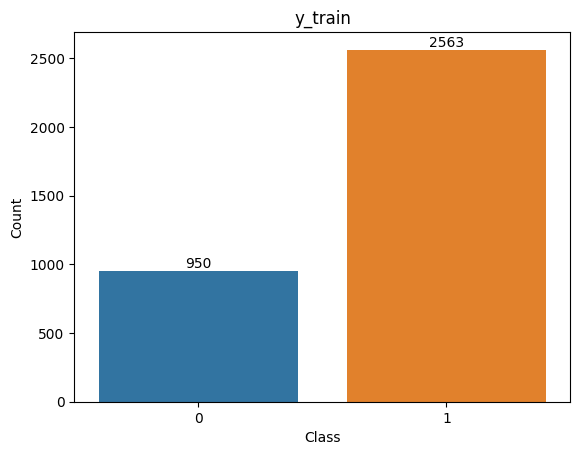

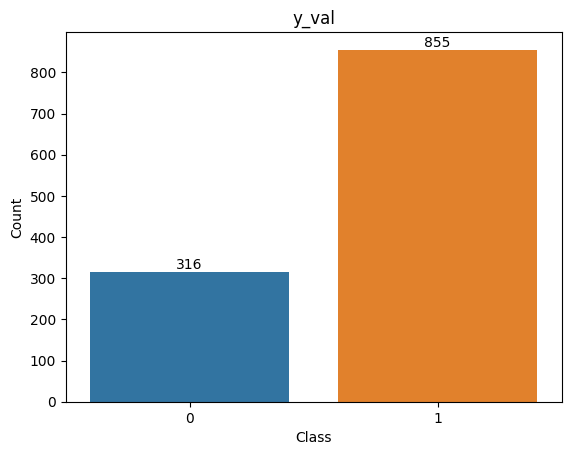

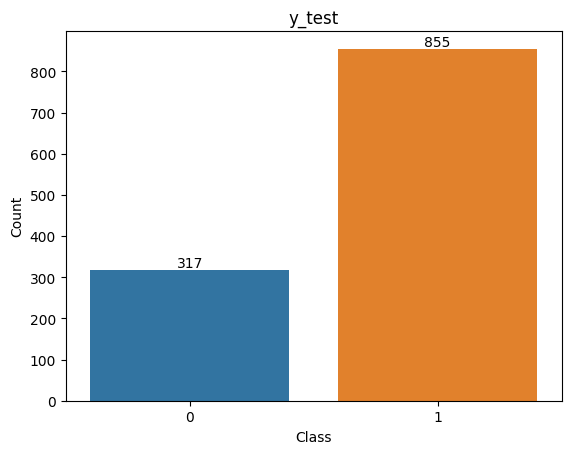

In [ ]:
# Plot class distribution
def plot_class_distribution(y, title):
    unique_values, value_counts = np.unique(y, return_counts=True)
    ax = sns.countplot(x=y)
    ax.bar_label(ax.containers[0])
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(unique_values)
    plt.show()
    print()


plot_class_distribution(y_train, 'y_train')
plot_class_distribution(y_val, 'y_val')
plot_class_distribution(y_test, 'y_test')

### Inception V3

In the next block of code, we will apply InceptionV3-specific preprocessing to the images using from tensorflow.keras.applications.resnet import preprocess_input.

In [ ]:
# Preprocess images for inception_v3
from tensorflow.keras.applications.inception_v3 import preprocess_input

def preprocess(image, label):
    image = preprocess_input(image)
    return image, label


X_train, y_train = preprocess(X_train, y_train)
X_val, y_val = preprocess(X_val, y_val)
X_test, y_test = preprocess(X_test, y_test)

Here we are loading the weights of the InceptionV3 pre-trained model

In [ ]:
# Build and compile the model
pretrained_model = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
pretrained_model.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In the below data augmentation layers are commented because during our experimentation phase whenever we used the data augmentation layer our model gave biased results.

In [ ]:
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))

# Define the data augmentation layer here, inside the model definition.
# data_augmentation_layer = tf.keras.Sequential([
#   # tf.keras.layers.RandomFlip('horizontal'),
#   tf.keras.layers.RandomRotation(0.1),
#   tf.keras.layers.RandomZoom(0.1),
#   tf.keras.layers.RandomContrast(0.2)
# ], name='data_augmentation')

# da = data_augmentation_layer(input_layer)

# x = pretrained_model(da, training=False)
x = pretrained_model(input_layer, training=False)
bl = tf.keras.layers.BatchNormalization()(x)

#x = tf.keras.layers.MaxPooling2D()(x)
flat = tf.keras.layers.Flatten()(bl)

drop = tf.keras.layers.Dropout(0.5)(flat)

dense = tf.keras.layers.Dense(512, activation='relu')(drop)
drop = tf.keras.layers.Dropout(0.5)(dense)
batch = tf.keras.layers.BatchNormalization()(drop)

dense = tf.keras.layers.Dense(32, activation='relu')(batch)
batch = tf.keras.layers.BatchNormalization()(dense)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(batch)

model_inception_v3 = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

model_inception_v3.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2048)                │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_94               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_95               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_96               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,878,689 (87.28 MB)

 Trainable params: 1,070,721 (4.08 MB)

 Non-trainable params: 21,807,968 (83.19 MB)

Here we compiling our model with optimizer, loss and metrces

In [ ]:
model_inception_v3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


This code snippet addresses the issue of class imbalance in the training data by calculating class weights. It uses the compute_class_weight function from scikit-learn with the class_weight='balanced' option. This automatically assigns higher weights to minority classes and lower weights to majority classes, helping the model learn more effectively from all classes. The calculated weights are then converted into a dictionary format for use during model training.

In [ ]:

# Calculate class weights
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))


Here, we are training the ResNet50 model using the fit method. We provide the training data (X_train, y_train), set the batch size to 32, and train for 50 epochs. We also use validation data (X_val, y_val) to monitor performance during training and apply class weights to handle class imbalance.

In [ ]:

# Train the model
history = model_inception_v3.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    verbose=1
)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 213ms/step - accuracy: 0.8308 - loss: 0.3852 - val_accuracy: 0.8232 - val_loss: 0.4468
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.9036 - loss: 0.2445 - val_accuracy: 0.8386 - val_loss: 0.3703
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9211 - loss: 0.2041 - val_accuracy: 0.9137 - val_loss: 0.2777
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9161 - loss: 0.2107 - val_accuracy: 0.9402 - val_loss: 0.2132
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9244 - loss: 0.1947 - val_accuracy: 0.9428 - val_loss: 0.1671
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9321 - loss: 0.1743 - val_accuracy: 0.9419 - val_loss: 0.1531
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9436 - loss: 0.1428 - val_accuracy: 0.9351 - val_loss: 0.1830
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.9275 - loss: 0.1693 - val_ac

This plot shows the model performance during training.

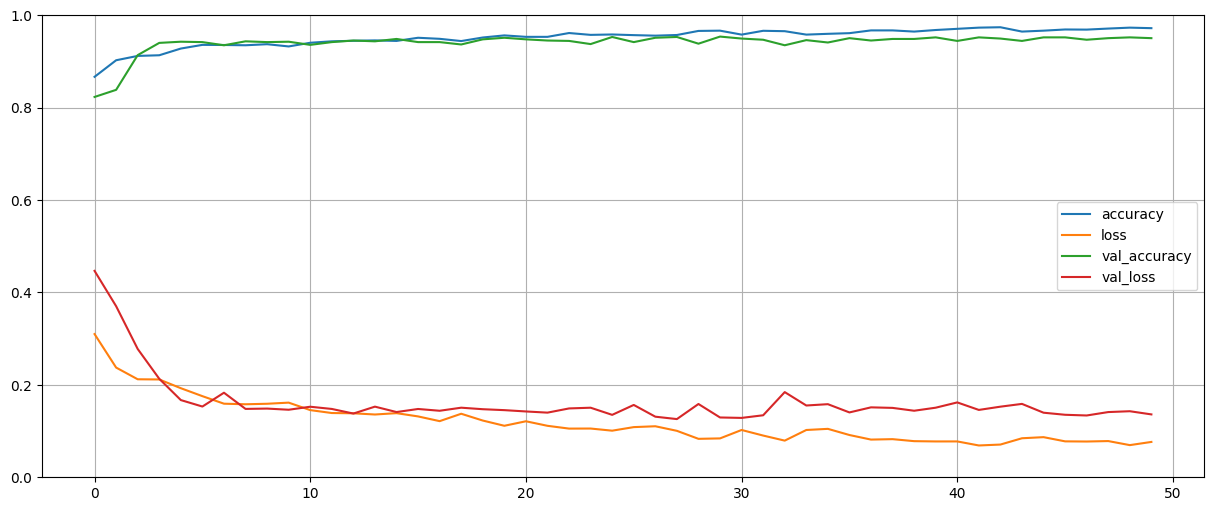

In [ ]:
# Plot training history
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(15, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()



Evaluation of model performance using unseen or test dataset

In [ ]:
# Evaluate the model
model_inception_v3.evaluate(X_test, y_test)


37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.9602 - loss: 0.1467


[0.1780996322631836, 0.9505119323730469]

Here predicting for test data, converts the probabilities into class labels (0 or 1) using a threshold of 0.5 and prints classification report on test data using metrics like precision, recall, F1-score, and support, broken down by class.

In [ ]:

# Predict and evaluate
y_pred = model_inception_v3.predict(X_test, verbose=1)
y_pred = (y_pred > 0.5).astype(int).reshape(-1)


class_labels = ['NORMAL', 'PNEUMONIA']

print(classification_report(y_test, y_pred, target_names=class_labels))


37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step
              precision    recall  f1-score   support

      NORMAL       0.90      0.92      0.91       317
   PNEUMONIA       0.97      0.96      0.97       855

    accuracy                           0.95      1172
   macro avg       0.93      0.94      0.94      1172
weighted avg       0.95      0.95      0.95      1172



Using confusion matrix to see that how many prediction are right and how many are wrongs.

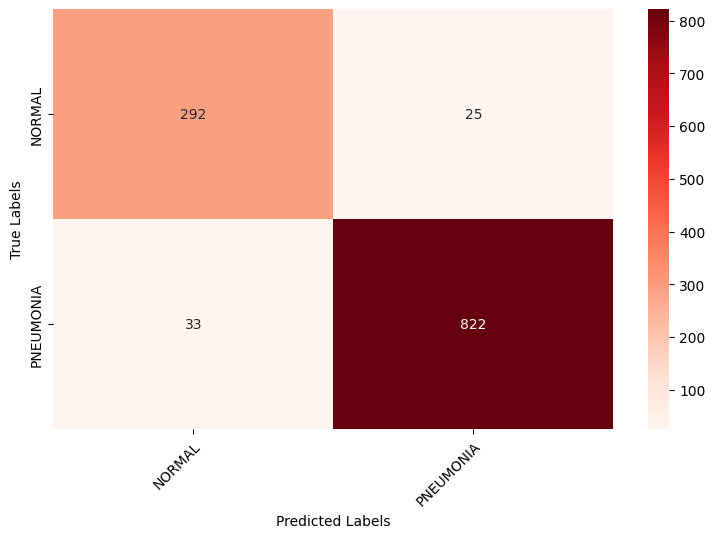

In [ ]:

# Plot confusion matrix
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
labels = list(class_labels)
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', xticklabels=labels, yticklabels=labels)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.2)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Result

Overall our model performed very well and achieved 95% accuracy. The performance can be further improved if we use another model or fine-tune model parameters.